In [10]:
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from Payne.fitting.fitutils import airtovacuum
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from scipy import constants
speedoflight = constants.c / 1000.0

In [3]:
def getdata(catfile=None,gaiaid=None,starind=None):
    th5 = h5py.File(catfile,'r')
    cat_i = Table(th5['catalog'][()])

    if gaiaid != None:
        t = th5[f'{gaiaid}']
        cat_ii = cat_i[cat_i['GAIAEDR3_ID'] == gaiaid]
        cat = {x:cat_ii[x][0] for x in cat_ii.keys()}

    elif starind != None:
        cat_ii = cat_i[starind]
        cat = {x:cat_ii[x] for x in cat_ii.keys()}
        
        gaiaid = cat['GAIAEDR3_ID']
        t = th5[f'{gaiaid}']
                
    header = {ii:th5['header'][ii][()] for ii in th5['header'].keys()}
    hdr_date = header['DATE-OBS']
    location = EarthLocation.of_site('MMT')

    sc = SkyCoord(ra=cat['GAIAEDR3_RA']*u.deg,dec=cat['GAIAEDR3_DEC']*u.deg)
    barycorr = sc.radial_velocity_correction(obstime=Time(hdr_date), location=location)
    HC = float(barycorr.to(u.km/u.s).value)

    out = {}
    out['spec'] = {}
    out['phot'] = {}
    
    # spec
    out['spec']['obs_wave']  = (1.0 - (HC/speedoflight)) * airtovacuum(t['wave'][()])
    out['spec']['obs_flux']  = t['flux'][()]
    out['spec']['obs_eflux'] = t['eflux'][()]

    # medflux = np.nanmedian(out['spec']['obs_flux'])
    # out['spec']['obs_flux'] = out['spec']['obs_flux'] / medflux
    # out['spec']['obs_eflux'] = out['spec']['obs_eflux'] / medflux

    SNR = np.nanmedian(out['spec']['obs_flux']/out['spec']['obs_eflux'])
    out['spec']['SNR'] = SNR
    out['spec']['date'] = hdr_date
    out['spec']['HC'] = HC

    # phot
    phot = t['phot']
    filterarr = list(phot.keys())
    usedfilters = []
    
    for ff in filterarr:            
        phot_i = phot[ff][()]
        if np.isfinite(phot_i[0]) & (phot_i[1] > 0.0):
            if 'Gaia' in ff:
                ff = ff.replace('EDR3', 'DR3')
            if 'PS_y' in ff:
                print(f"Skipping filter {ff}")
                continue
            out['phot'][ff] = [phot_i[0],phot_i[1]]
            usedfilters.append(ff)
    out['phot_filtarr'] = usedfilters
    
    # parallax
    out['parallax'] = [cat['GAIAEDR3_PARALLAX'],cat['GAIAEDR3_PARALLAX_ERROR']]
    
    # define some cluster guesses
    if 'ic348' in catfile:
        Avest = 1.91 # Cantat-Gaudin+ 2020
        RVest = 15.44 # Tarricq+ 2021
    elif 'm37' in catfile:
        Avest = 0.75
        RVest = 8.81
    elif 'm3' in catfile:
        Avest = 0.03 # Harris 1996
        RVest = -147.2 # BAUMGARDT H. and HILKER M 2018
    elif 'm67' in catfile:
        Avest = 0.07
        RVest = 34.18
    elif 'ngc6791' in catfile:
        Avest = 0.70
        RVest = -47.75
    elif 'ngc6811' in catfile:
        Avest = 0.09
        RVest = 7.17
    elif 'ngc6819' in catfile:
        Avest = 0.40
        RVest = 2.80
    elif 'ngc6866' in catfile:
        Avest = 0.48
        RVest = 12.44
    else:
        print('Could not understand cluster name in filename, setting Avest = 0.1 and RVest = 0.0')
        Avest = 0.1
        RVest = 0.0
    
    out['Avest'] = Avest
    out['RVest'] = RVest

    out['Teff']   = 5770.0
    out['[Fe/H]'] = 0.0
    out['[a/Fe]'] = 0.0
    out['log(g)'] = 4.5
    out['log(R)'] = 0.0

    return out

In [4]:
def getall(gaiaid=None,date=None,cluster=None):
    
    #datasrcstr ='/Reduced Spectra/'
    
    filesrstr = 'Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5'
    # list of all possible HDF5 files
    #if cluster != None:
     #   filesrstr += f'{cluster}*'
    #if date != None:
     #   filesrstr += f'{date}*'

    #filesrstr += '.h5'
    flist = glob.glob(filesrstr)

    # get the HDF5 files with this star
    workingfiles = []
    for ff in flist:
        with h5py.File(ff,'r') as th5:
            if f'{gaiaid}' in list(th5.keys()):
                workingfiles.append(ff)
    
    if len(workingfiles) == 0:
        print(f'Could Not Find Any Spectra for GaiaID = {gaiaid}')
        return None
    
    out = {}
    out['spec'] = []
    out['specname'] = []
    for ii,ww in enumerate(workingfiles):
        data = getdata(catfile=ww,gaiaid=gaiaid)
        if ii == 0:
            out['phot']     = data['phot']
            out['phot_filtarr'] = data['phot_filtarr']
            out['parallax'] = data['parallax']
            out['Avest']    = data['Avest']
            out['RVest']    = data['RVest']

            out['Teff']   = data['Teff']
            out['[Fe/H]'] = data['[Fe/H]']
            out['[a/Fe]'] = data['[a/Fe]']
            out['log(g)'] = data['log(g)']
            out['log(R)'] = data['log(R)']

        if data['spec']['SNR'] >= 3.0:
            out['spec'].append(data['spec'])
            out['specname'].append(ww.split('/')[-1])
    
    if len(out['spec']) > 2:
        # sort spectra by date
        sortind = np.argsort(out['specname'])
        out['spec'] = list(np.array(out['spec'])[sortind])
        out['specname'] = list(np.array(out['specname'])[sortind])

    return out

In [19]:
data = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128144342281521152)
data

{'spec': {'obs_wave': array([5161.66156938, 5161.69749841, 5161.7334274 , ..., 5291.60623941,
         5291.63818628, 5291.67013123]),
  'obs_flux': array([0.89629948, 0.89138159, 0.88307536, ..., 1.08778064, 1.08913934,
         1.13714287]),
  'obs_eflux': array([0.02253973, 0.02323837, 0.02389683, ..., 0.02334522, 0.02436681,
         0.02440106]),
  'SNR': 42.750555919908024,
  'date': b'2008-10-19T05:03:18',
  'HC': -11.77144333621705},
 'phot': {'2MASS_H': [12.479000091552734, 0.05462600108698047],
  '2MASS_J': [12.736000061035156, 0.05423098734219094],
  '2MASS_Ks': [12.425000190734863, 0.053851647905320474],
  'GaiaDR3_BP': [13.954702334391069, 0.050006747533939064],
  'GaiaDR3_G': [13.669642, 0.05000059744487587],
  'GaiaDR3_RP': [13.226369674643447, 0.05000351324455481],
  'WISE_W1': [12.404074668884277, 0.05003164547216465],
  'WISE_W2': [12.442203521728516, 0.05003164547216465]},
 'phot_filtarr': ['2MASS_H',
  '2MASS_J',
  '2MASS_Ks',
  'GaiaDR3_BP',
  'GaiaDR3_G',
  'GaiaD

In [20]:
wavelength = data['spec']['obs_wave']
wavelength

array([5161.66156938, 5161.69749841, 5161.7334274 , ..., 5291.60623941,
       5291.63818628, 5291.67013123])

In [21]:
flux = data['spec']['obs_flux']
flux

array([0.89629948, 0.89138159, 0.88307536, ..., 1.08778064, 1.08913934,
       1.13714287])

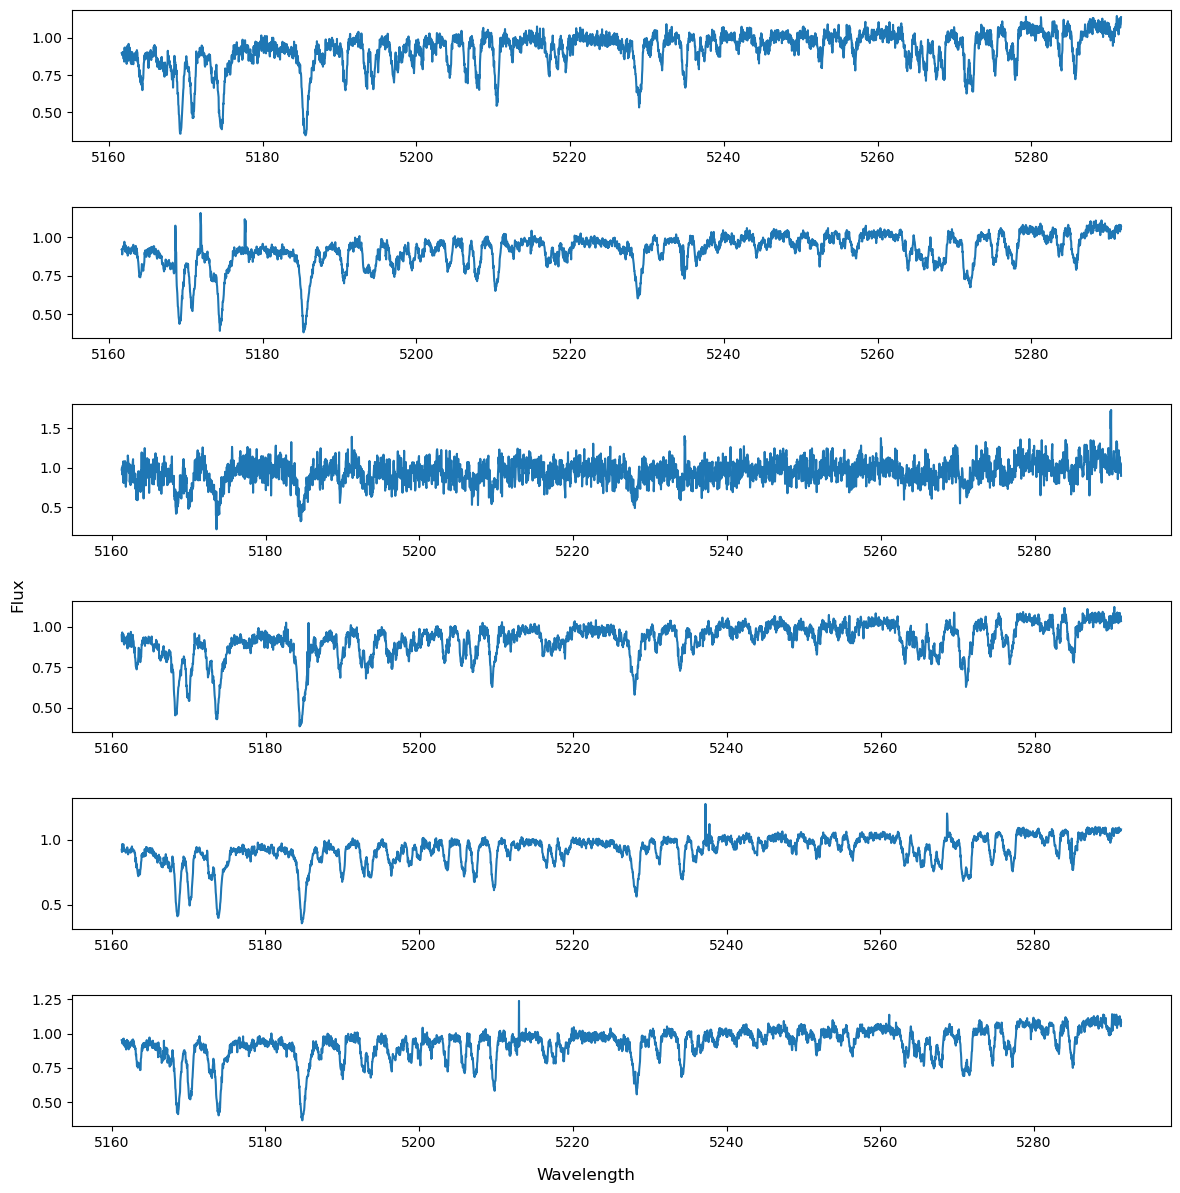

In [62]:
#gaia_id = 2128144342281521152
fig, ax = plt.subplots(6, 1, figsize=(12, 12))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128144342281521152)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128144342281521152)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128144342281521152)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5', gaiaid=2128144342281521152)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])
obs5 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0623_hectochelle_NGC6811_2019b_1.8441.h5', gaiaid=2128144342281521152)
ax[4].plot(obs5['spec']['obs_wave'], obs5['spec']['obs_flux'])
obs6 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5', gaiaid=2128144342281521152)
ax[5].plot(obs6['spec']['obs_wave'], obs6['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

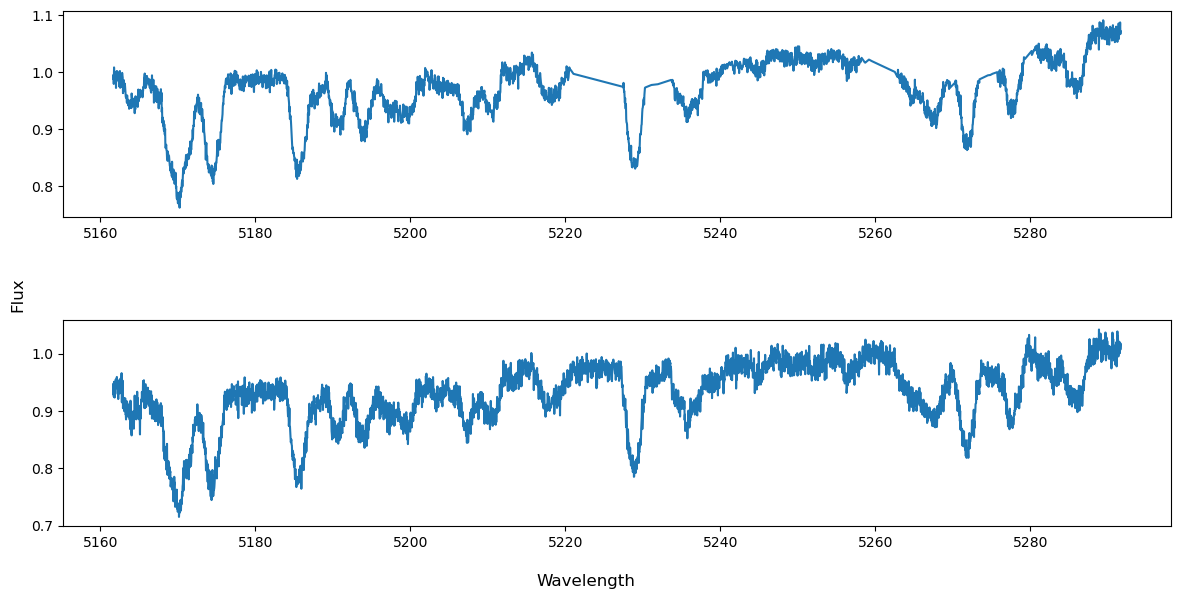

In [63]:
#gaia_id = 2128153477671286784
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128153477671286784)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1203_ngc6811bright_nov09_4.4154.h5', gaiaid=2128153477671286784)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y


Text(0, 0.5, 'Flux')

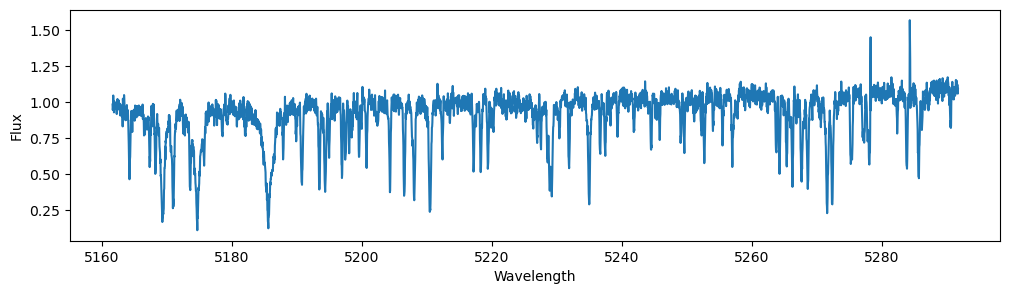

In [65]:
#gaia_id = 2128132694330246144
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128132694330246144)
ax.plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])

ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux")

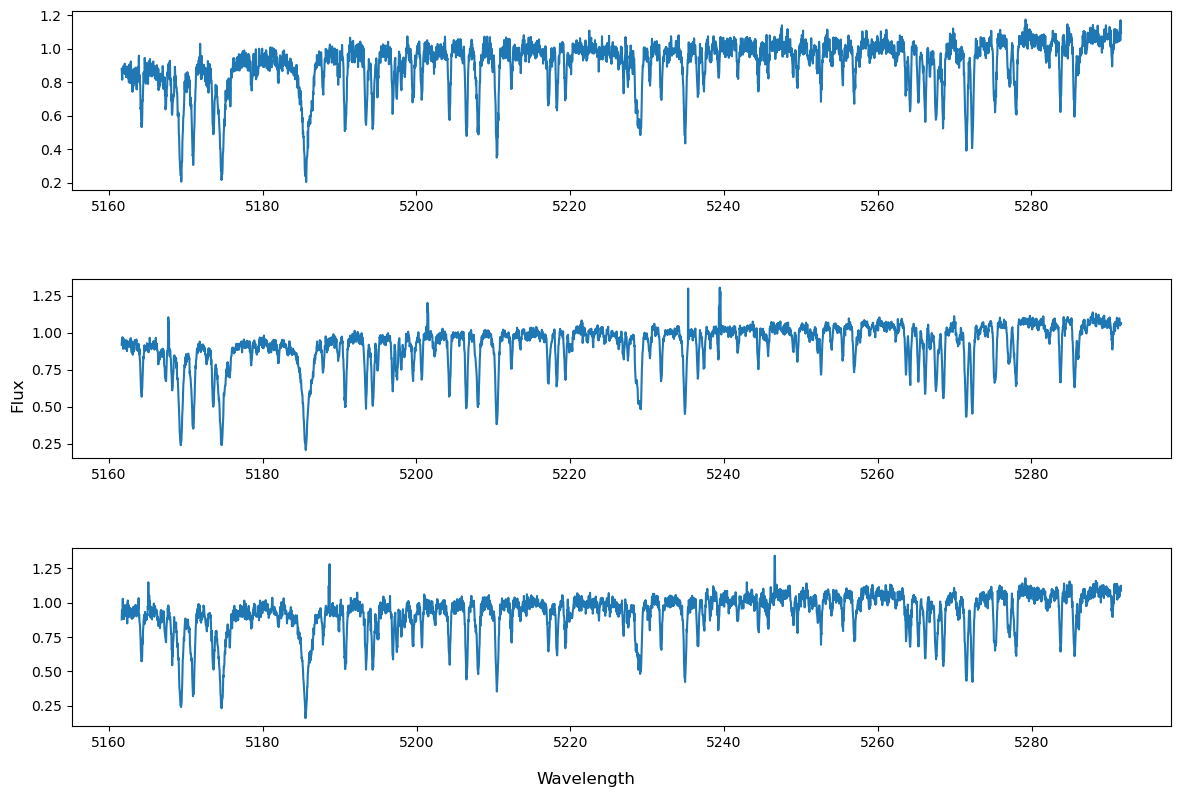

In [75]:
#gaia_id = 2128120702781492352
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128120702781492352)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128120702781492352)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1202_ngc6811bright_nov09_3.4041.h5', gaiaid=2128120702781492352)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

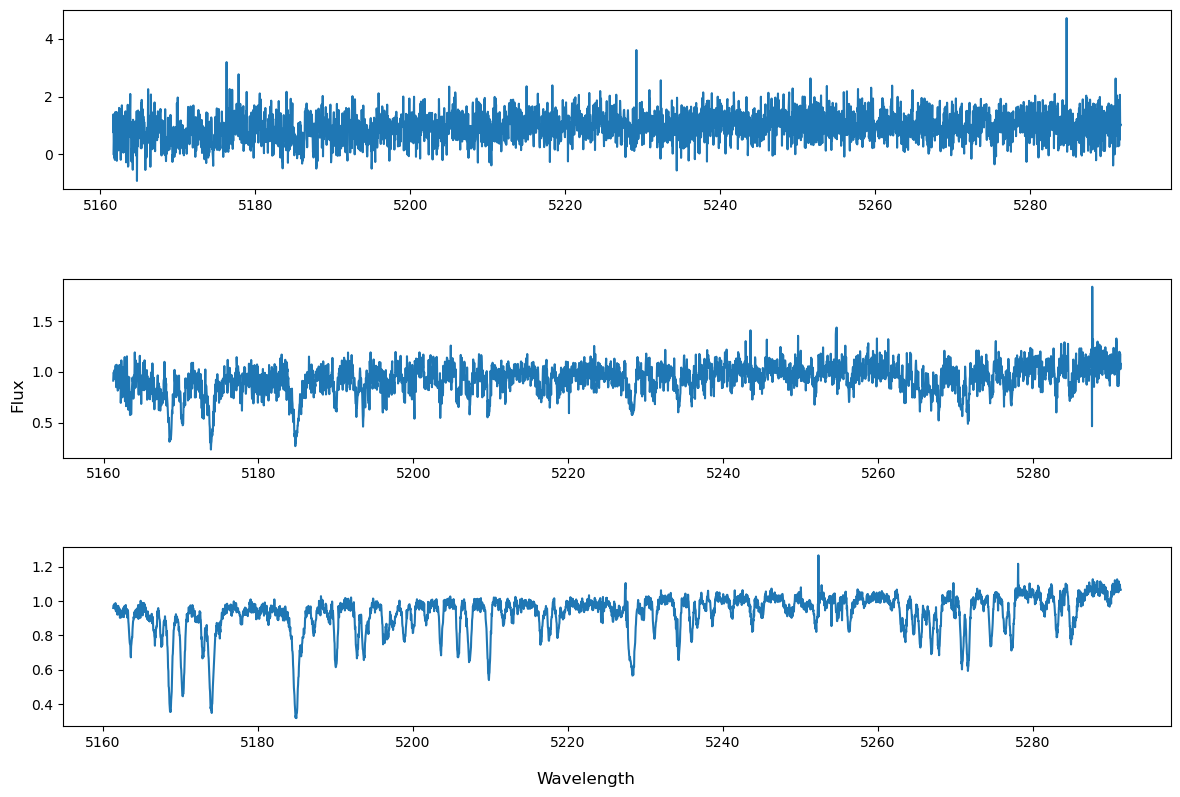

In [67]:
#gaia_id = 2128109123549687680
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128109123549687680)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128109123549687680)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5', gaiaid=2128109123549687680)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


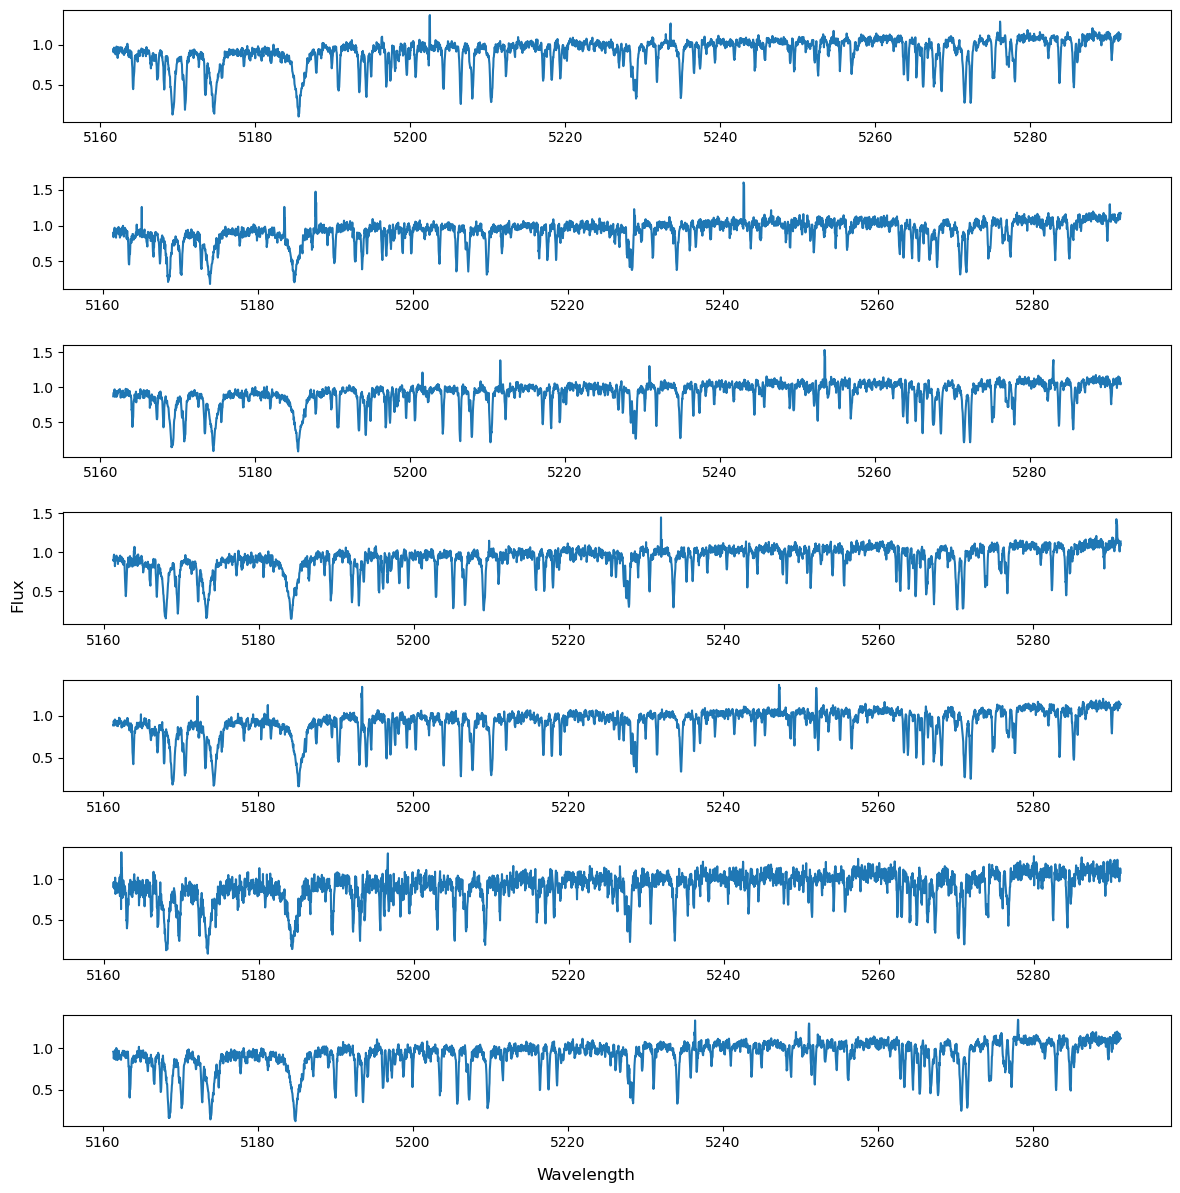

In [72]:
#gaia_id = 2128125375705878528
fig, ax = plt.subplots(7, 1, figsize=(12, 12))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128125375705878528)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0627_ngc6811_may2010_trunc_3.6386.h5', gaiaid=2128125375705878528)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.1121_ngc6811_sep10_faint_3.7448.h5', gaiaid=2128125375705878528)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0511_ngc6811_may2012_1.0388.h5', gaiaid=2128125375705878528)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])
obs5 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0607_ngc6811_jun2012_1.1317.h5', gaiaid=2128125375705878528)
ax[4].plot(obs5['spec']['obs_wave'], obs5['spec']['obs_flux'])
obs6 = getdata(catfile='Reduced Spectra/data_ngc6811_2016.0429_ngc6811_apr2016_2.3750.h5', gaiaid=2128125375705878528)
ax[5].plot(obs6['spec']['obs_wave'], obs6['spec']['obs_flux'])
obs7 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5', gaiaid=2128125375705878528)
ax[6].plot(obs7['spec']['obs_wave'], obs7['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

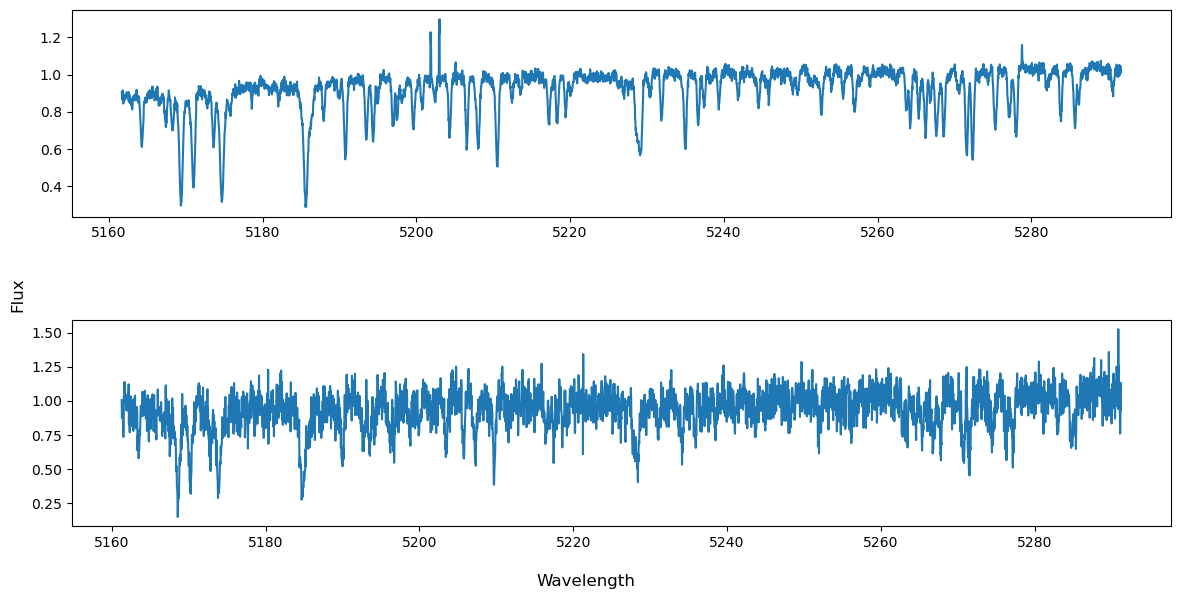

In [74]:
#gaia_id = 2128018963596952832
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128018963596952832)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128018963596952832)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


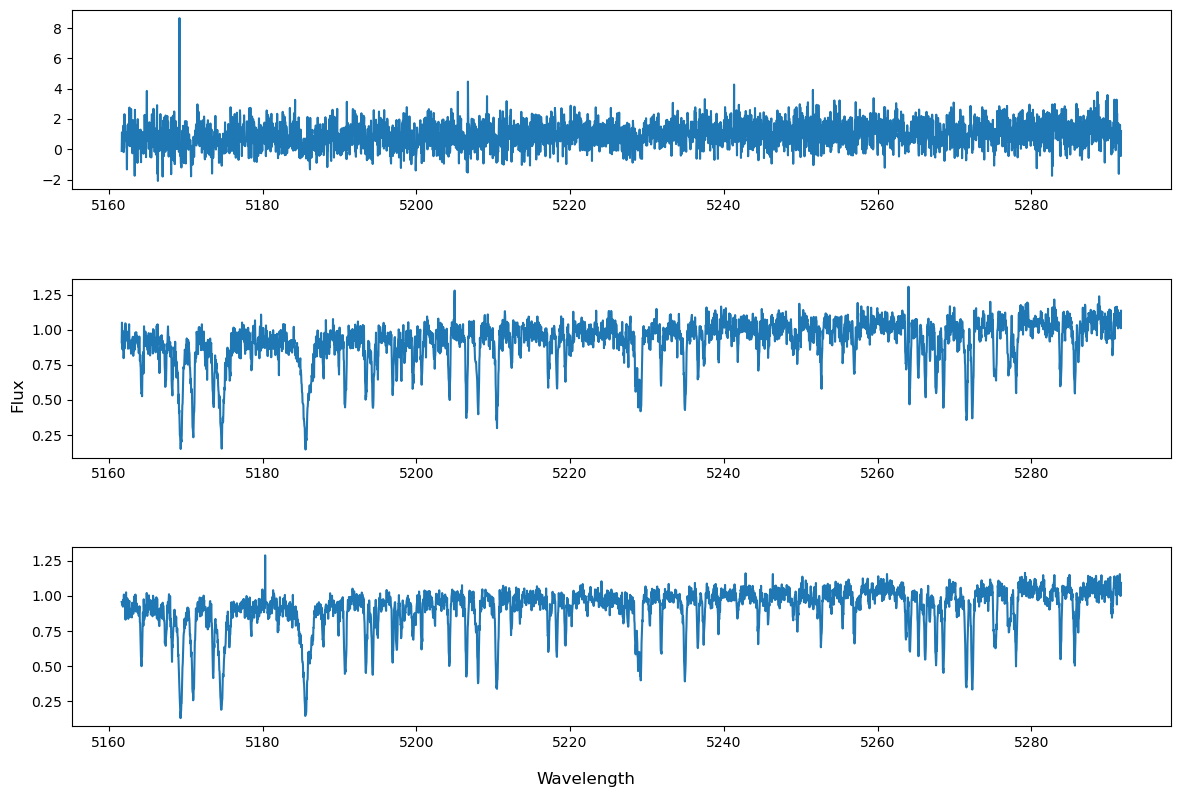

In [76]:
#gaia_id = 2128145957189232256
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128145957189232256)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1103_ngc6811_oct09_3.3506.h5', gaiaid=2128145957189232256)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1127_ngc6811bright_nov09_1.3626.h5', gaiaid=2128145957189232256)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

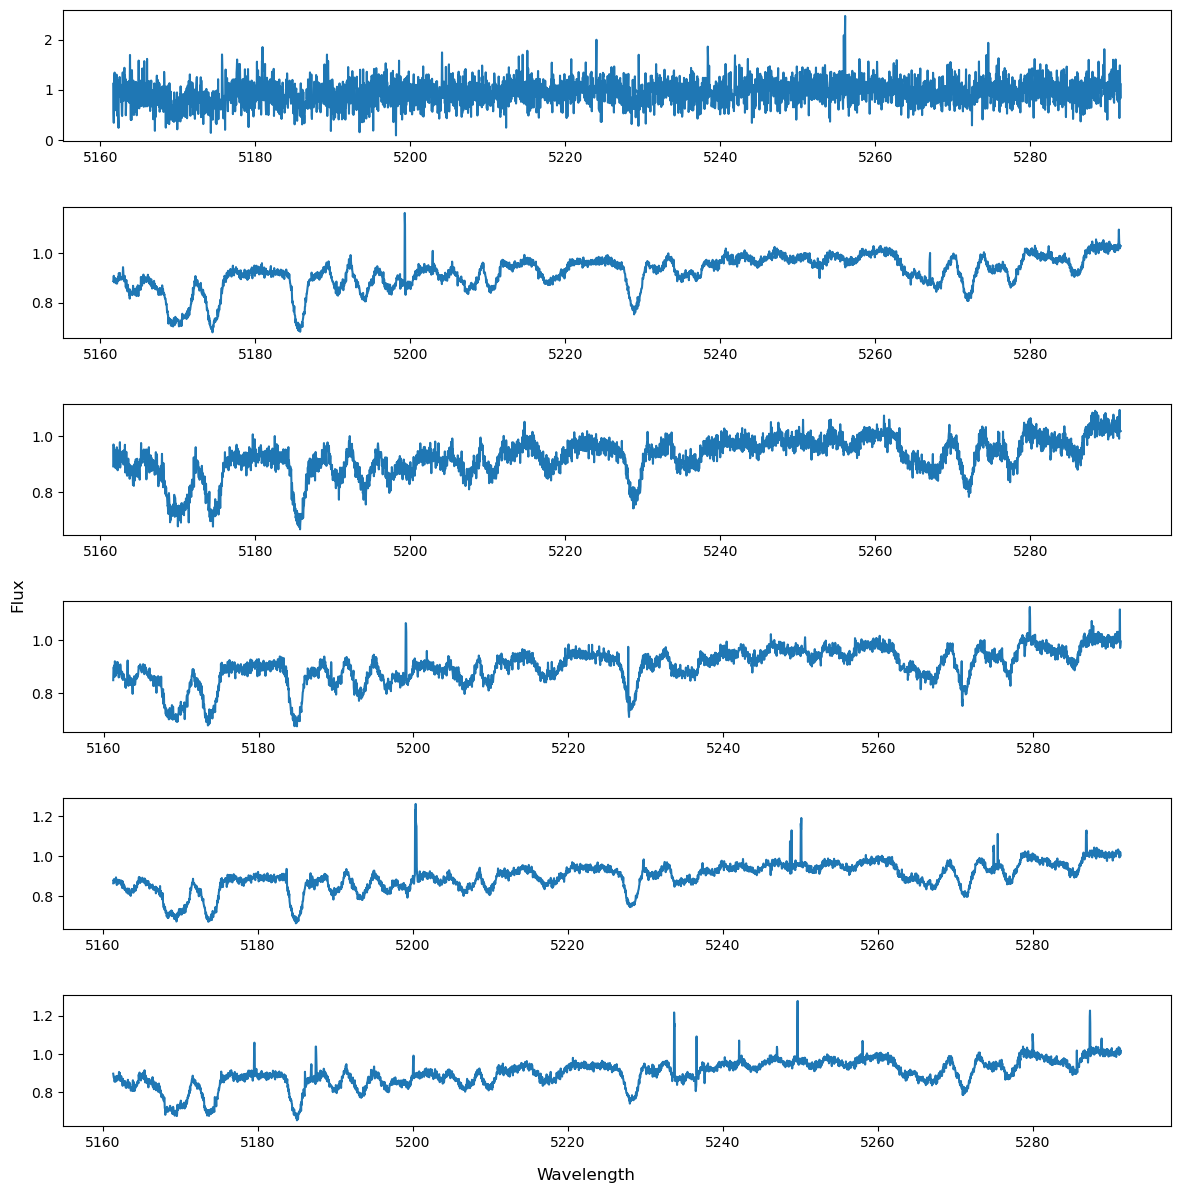

In [77]:
#gaia_id = 2128134824634071424
fig, ax = plt.subplots(6, 1, figsize=(12, 12))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128134824634071424)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128134824634071424)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1127_ngc6811bright_nov09_1.3626.h5', gaiaid=2128134824634071424)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5', gaiaid=2128134824634071424)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])
obs5 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0623_hectochelle_NGC6811_2019b_1.8441.h5', gaiaid=2128134824634071424)
ax[4].plot(obs5['spec']['obs_wave'], obs5['spec']['obs_flux'])
obs6 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5', gaiaid=2128134824634071424)
ax[5].plot(obs6['spec']['obs_wave'], obs6['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

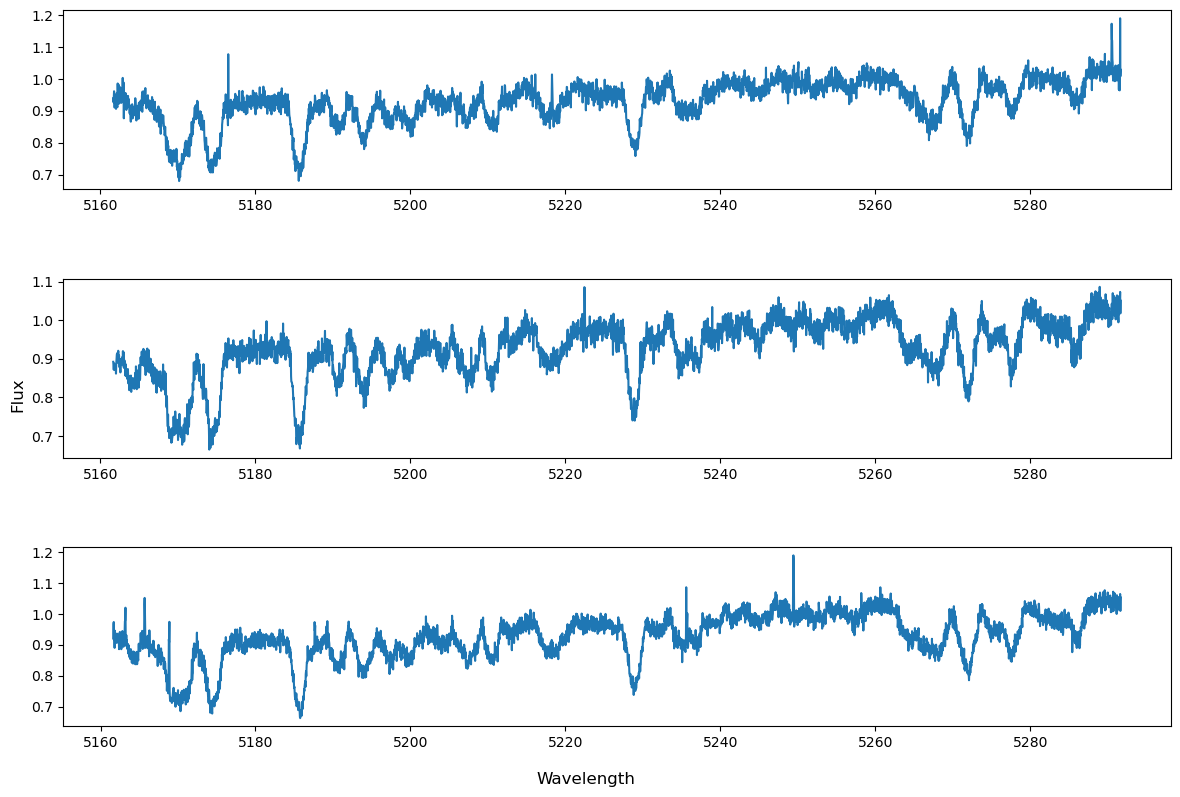

In [78]:
#gaia_id = 2128145166915272832
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2128145166915272832)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128145166915272832)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1202_ngc6811bright_nov09_3.4041.h5', gaiaid=2128145166915272832)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

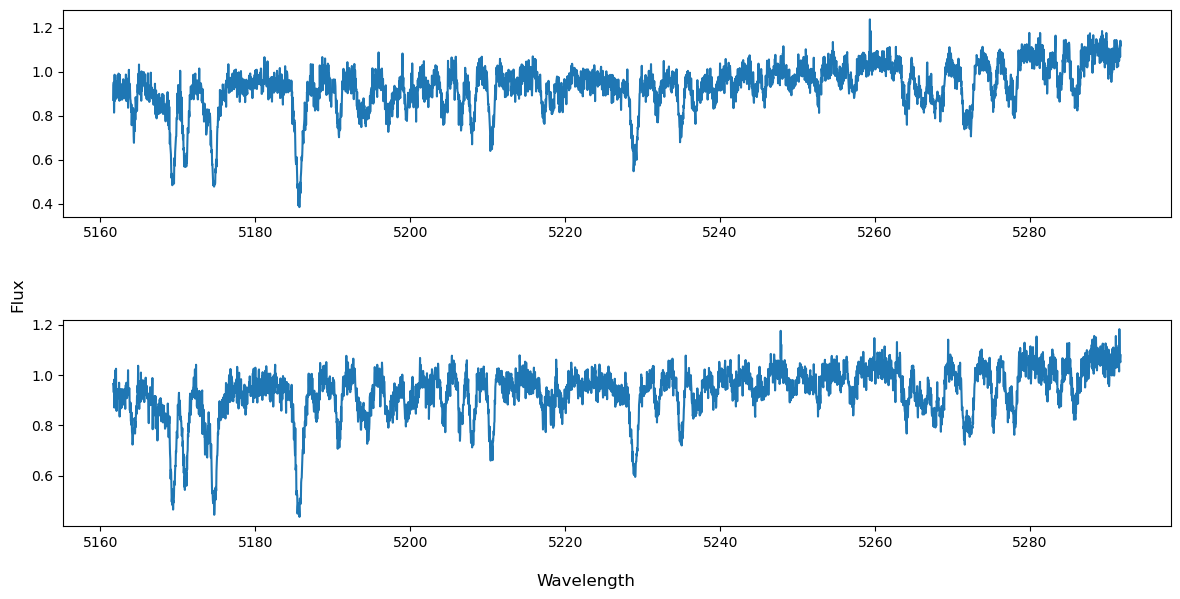

In [80]:
#gaia_id = 2128131216861484928
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1028_ngc6811_jul07_3.0705.h5', gaiaid=2128131216861484928)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128131216861484928)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y


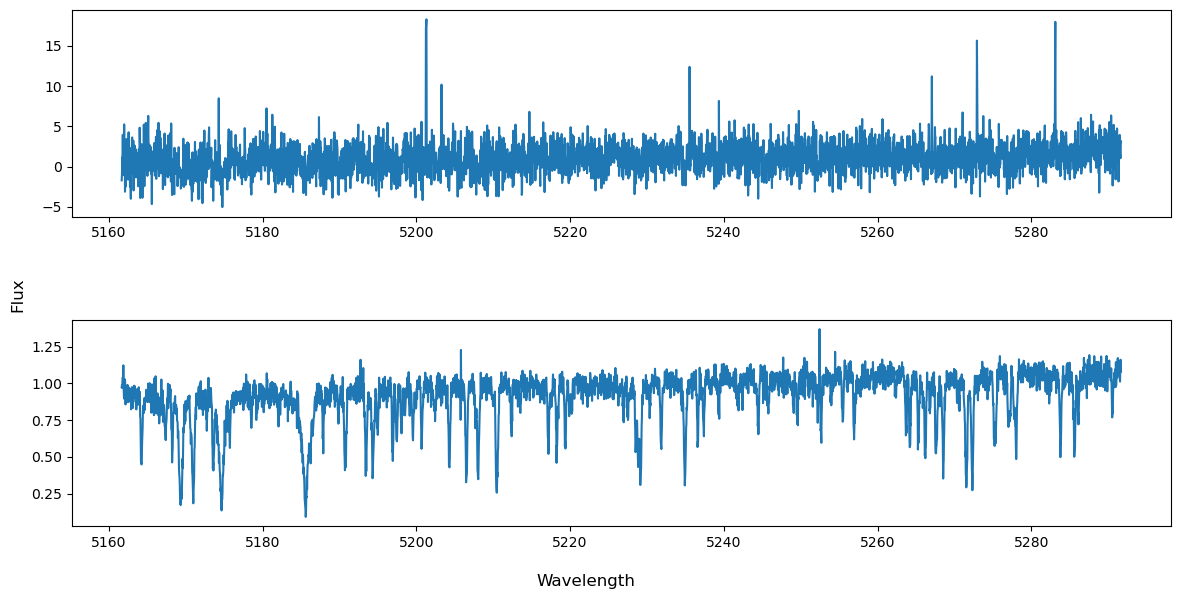

In [81]:
#gaia_id = 2128151008070805888
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128151008070805888)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1127_ngc6811bright_nov09_1.3626.h5', gaiaid=2128151008070805888)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

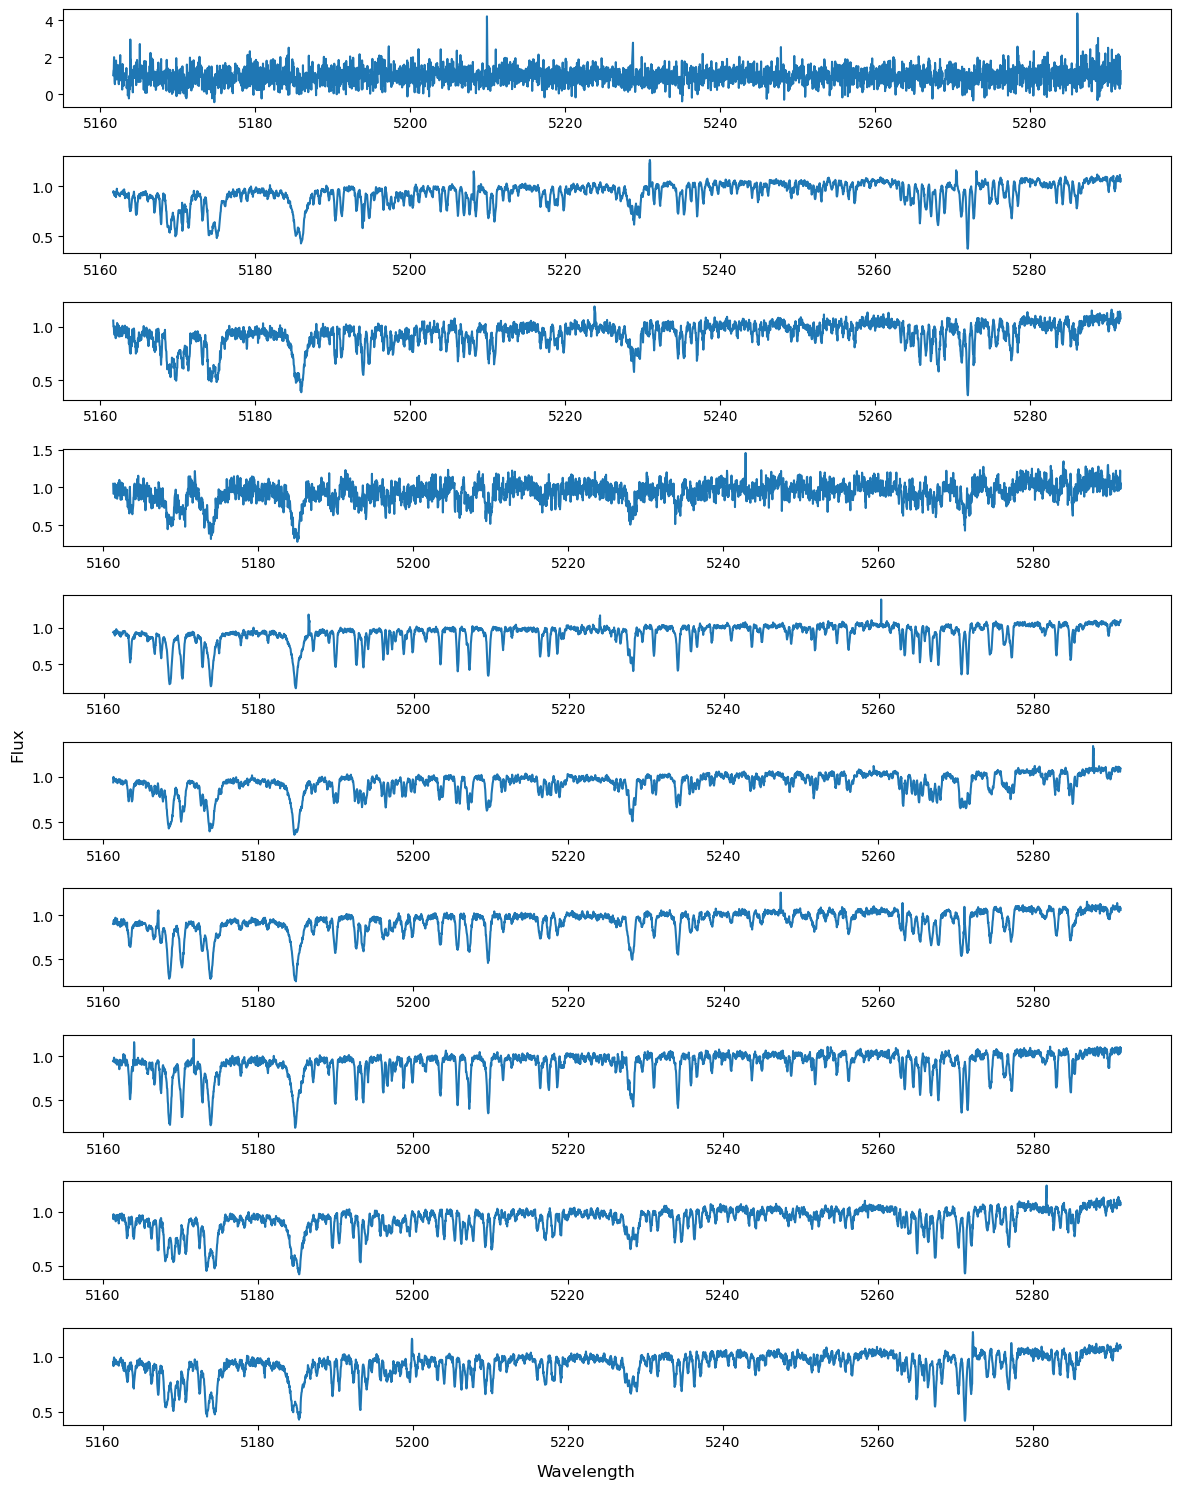

In [83]:
#gaia_id = 2128135546188203904
fig, ax = plt.subplots(10, 1, figsize=(12, 15))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128135546188203904)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128135546188203904)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1128_ngc6811bright_nov09_2.3763.h5', gaiaid=2128135546188203904)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128135546188203904)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])
obs5 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0511_ngc6811_may2012_1.0388.h5', gaiaid=2128135546188203904)
ax[4].plot(obs5['spec']['obs_wave'], obs5['spec']['obs_flux'])
obs6 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0607_ngc6811_jun2012_1.1317.h5', gaiaid=2128135546188203904)
ax[5].plot(obs6['spec']['obs_wave'], obs6['spec']['obs_flux'])
obs7 = getdata(catfile='Reduced Spectra/data_ngc6811_2016.0427_ngc6811_apr2016_1.3533.h5', gaiaid=2128135546188203904)
ax[6].plot(obs7['spec']['obs_wave'], obs7['spec']['obs_flux'])
obs8 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5', gaiaid=2128135546188203904)
ax[7].plot(obs8['spec']['obs_wave'], obs8['spec']['obs_flux'])
obs9 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0623_hectochelle_NGC6811_2019b_1.8441.h5', gaiaid=2128135546188203904)
ax[8].plot(obs9['spec']['obs_wave'], obs9['spec']['obs_flux'])
obs10 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5', gaiaid=2128135546188203904)
ax[9].plot(obs10['spec']['obs_wave'], obs10['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


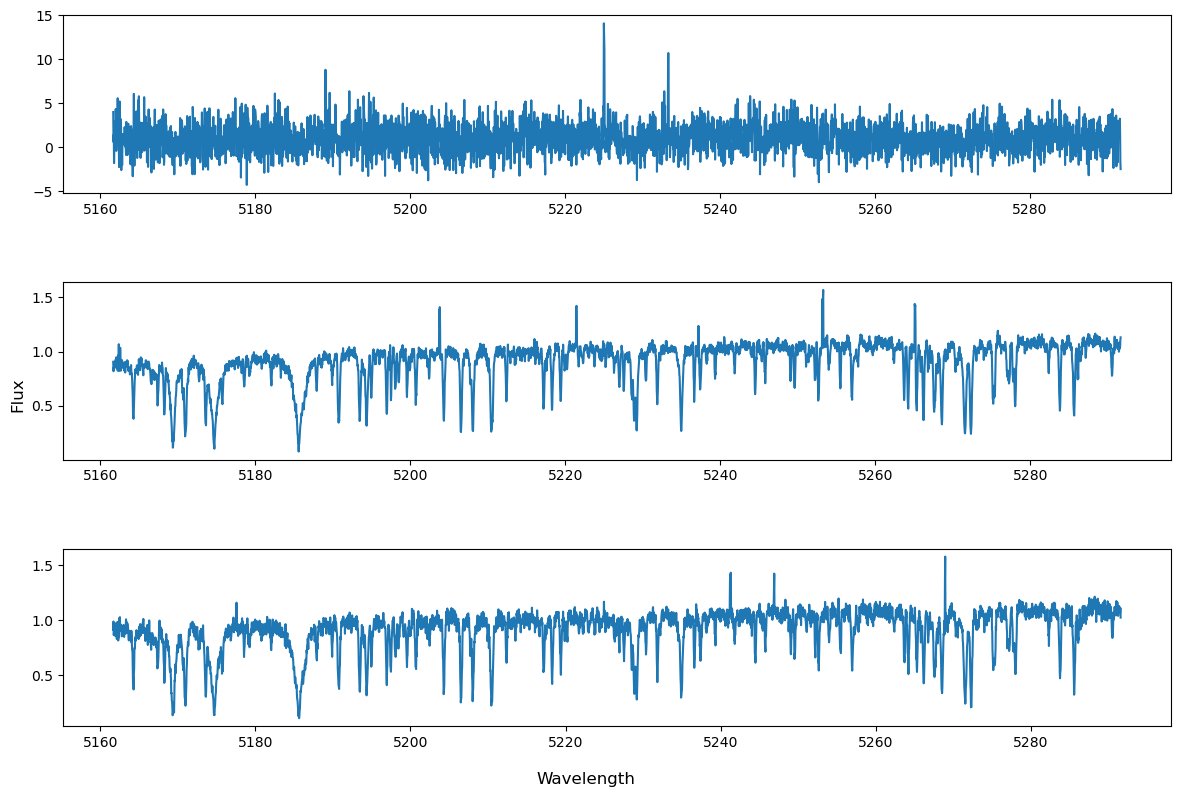

In [84]:
#gaia_id = 2128119087873695232
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128119087873695232)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128119087873695232)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.1121_ngc6811_sep10_faint_3.7448.h5', gaiaid=2128119087873695232)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

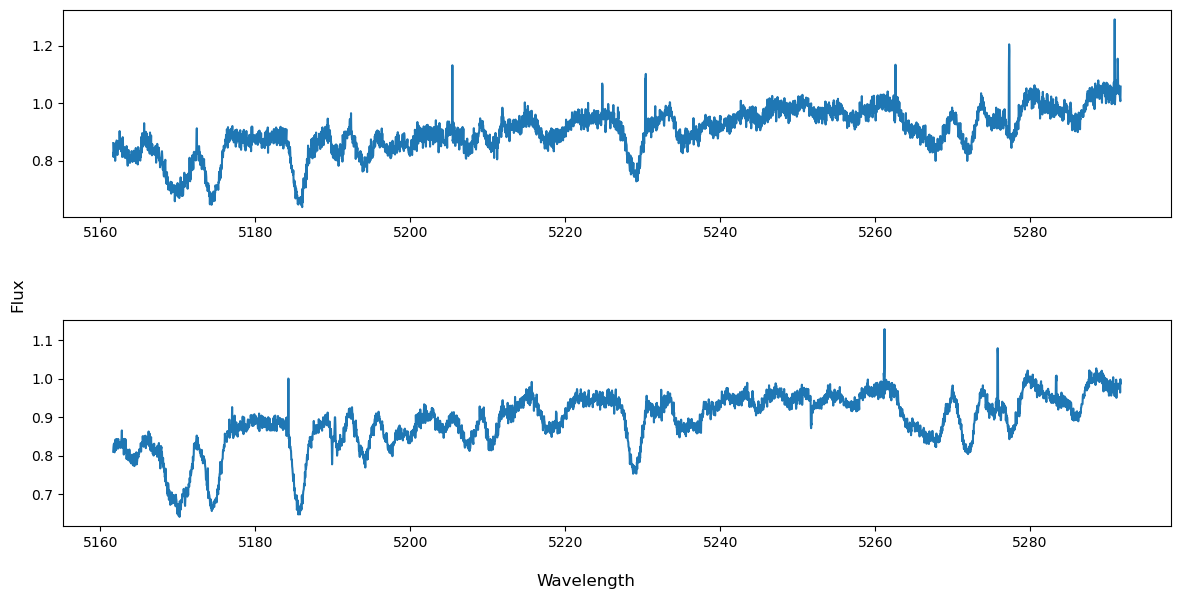

In [85]:
#gaia_id = 2128119671989265024
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2128119671989265024)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128119671989265024)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y


Text(0, 0.5, 'Flux')

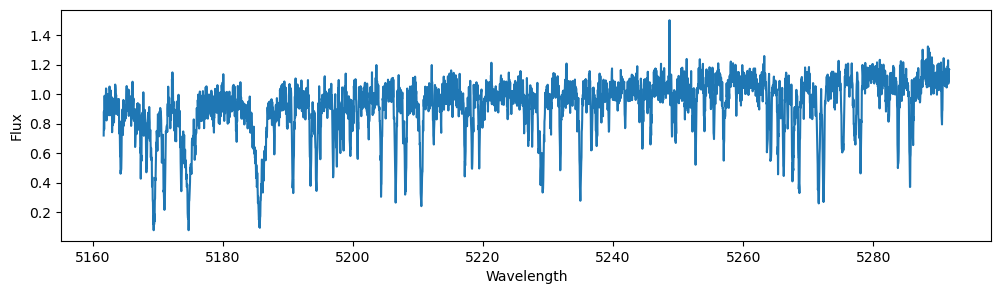

In [86]:
#gaia_id = 2128106477849445248
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1028_ngc6811_jul07_3.0705.h5', gaiaid=2128106477849445248)
ax.plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])

ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux")

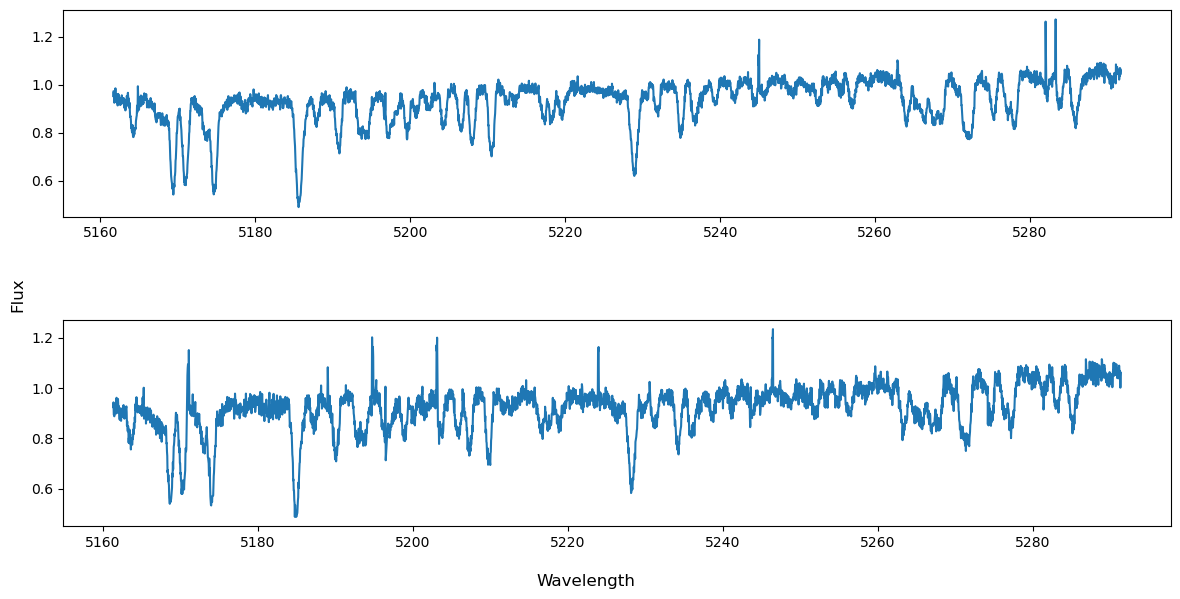

In [87]:
#gaia_id = 2128145506212004608
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1102_ngc6811_oct09_2.3426.h5', gaiaid=2128145506212004608)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0628_ngc6811_may2010_trunc_4.6455.h5', gaiaid=2128145506212004608)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y


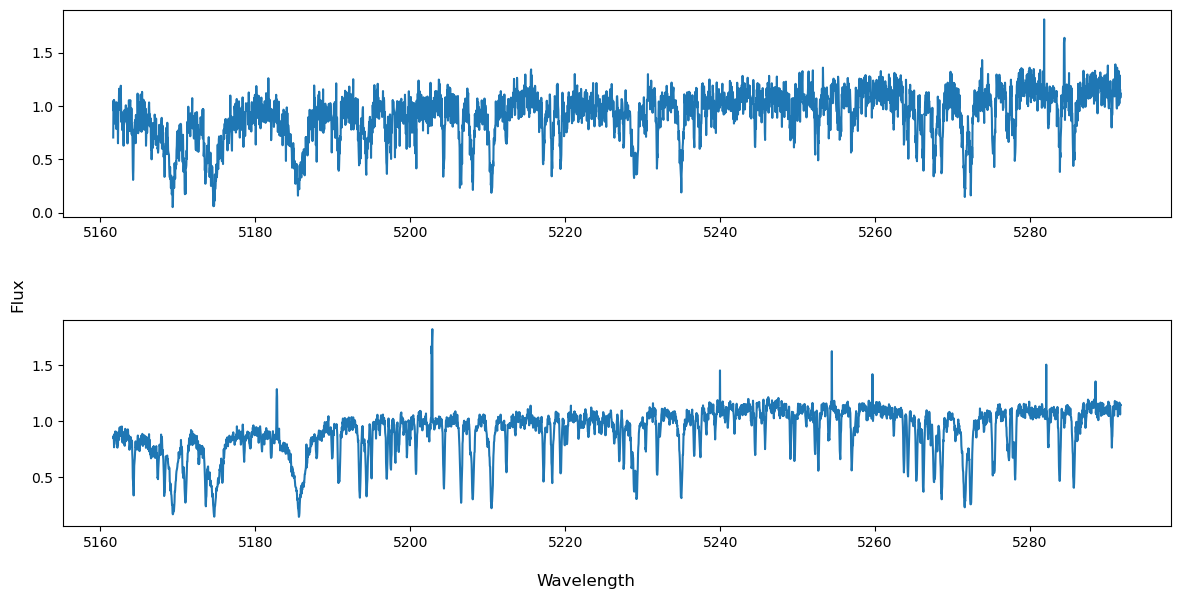

In [88]:
#gaia_id = 2128108024038073216
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2128108024038073216)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1109_ngc6811_nov08_1.3218.h5', gaiaid=2128108024038073216)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

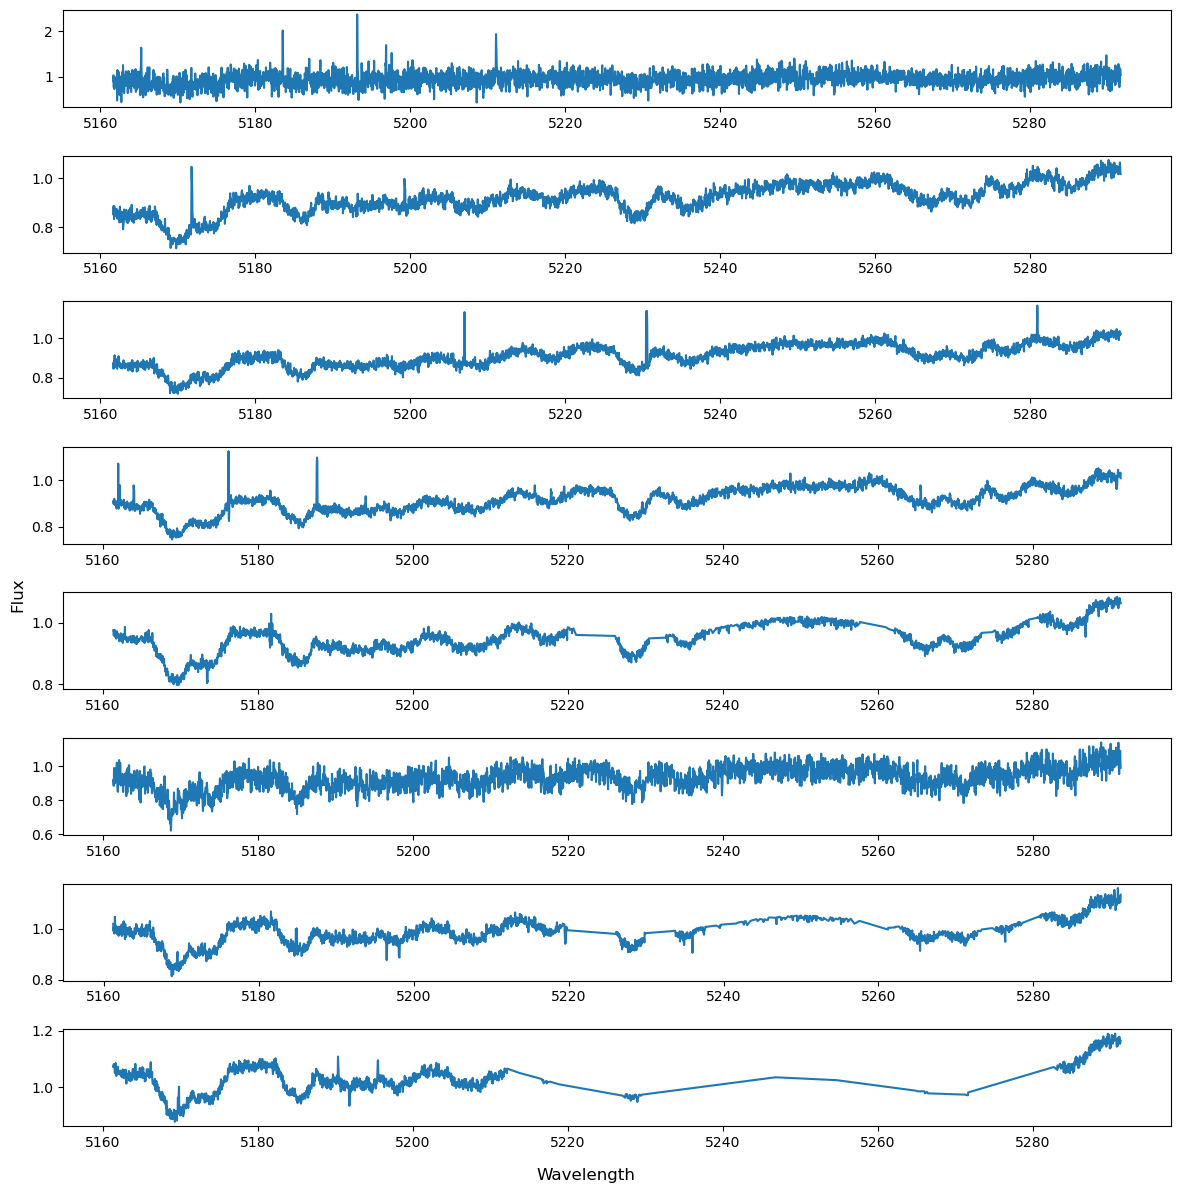

In [103]:
#gaia_id = 2128108913090657536
fig, ax = plt.subplots(8, 1, figsize=(12, 12))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128108913090657536)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128108913090657536)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1128_ngc6811bright_nov09_2.3763.h5', gaiaid=2128108913090657536)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0304_ngc6811_mar10_sort_1.5362.h5', gaiaid=2128108913090657536)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])
obs5 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0627_ngc6811_may2010_trunc_3.6386.h5', gaiaid=2128108913090657536)
ax[4].plot(obs5['spec']['obs_wave'], obs5['spec']['obs_flux'])
obs6 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128108913090657536)
ax[5].plot(obs6['spec']['obs_wave'], obs6['spec']['obs_flux'])
obs7 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5', gaiaid=2128108913090657536)
ax[6].plot(obs7['spec']['obs_wave'], obs7['spec']['obs_flux'])
obs8 = getdata(catfile='Reduced Spectra/data_ngc6811_2019.0623_hectochelle_NGC6811_2019b_1.8441.h5', gaiaid=2128108913090657536)
ax[7].plot(obs8['spec']['obs_wave'], obs8['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

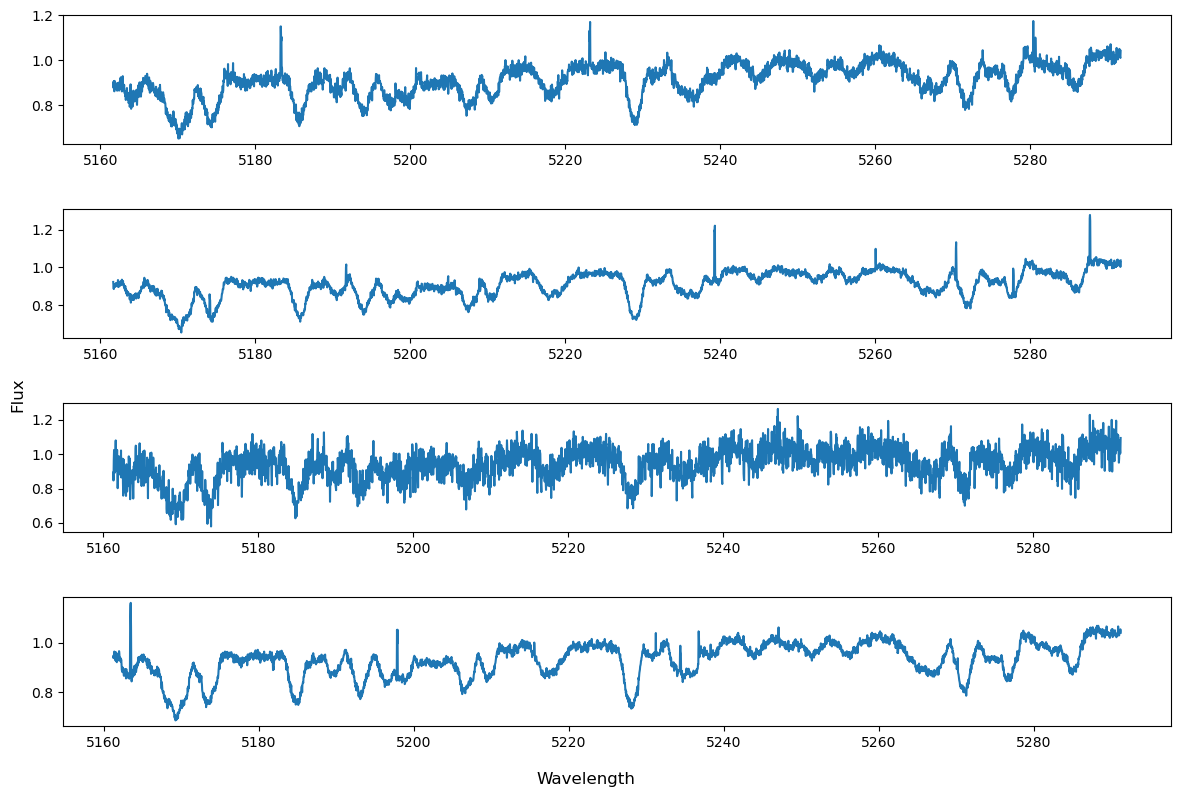

In [93]:
#gaia_id = 2080064515564300160
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2080064515564300160)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2080064515564300160)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2080064515564300160)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2016.0427_ngc6811_apr2016_1.3533.h5', gaiaid=2080064515564300160)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

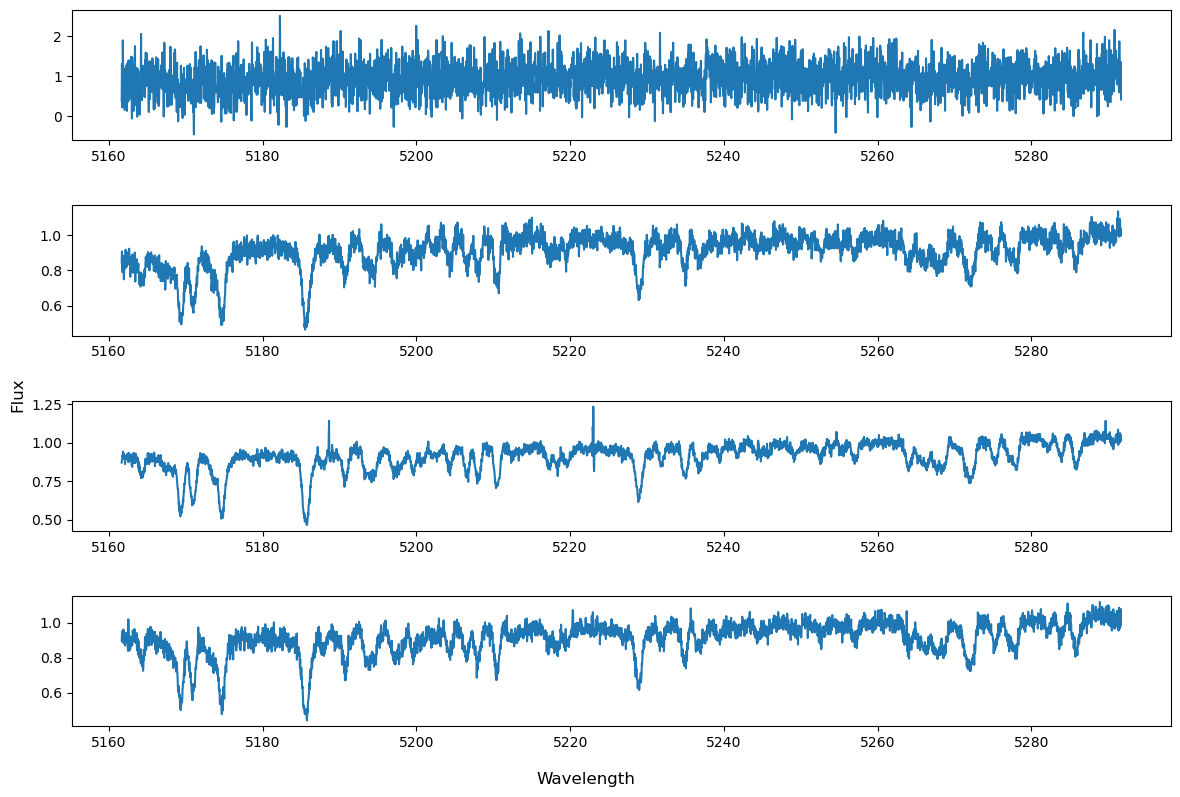

In [94]:
#gaia_id = 2128118057081550464
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128118057081550464)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128118057081550464)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1102_ngc6811_oct09_2.3426.h5', gaiaid=2128118057081550464)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1203_ngc6811bright_nov09_4.4154.h5', gaiaid=2128118057081550464)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y


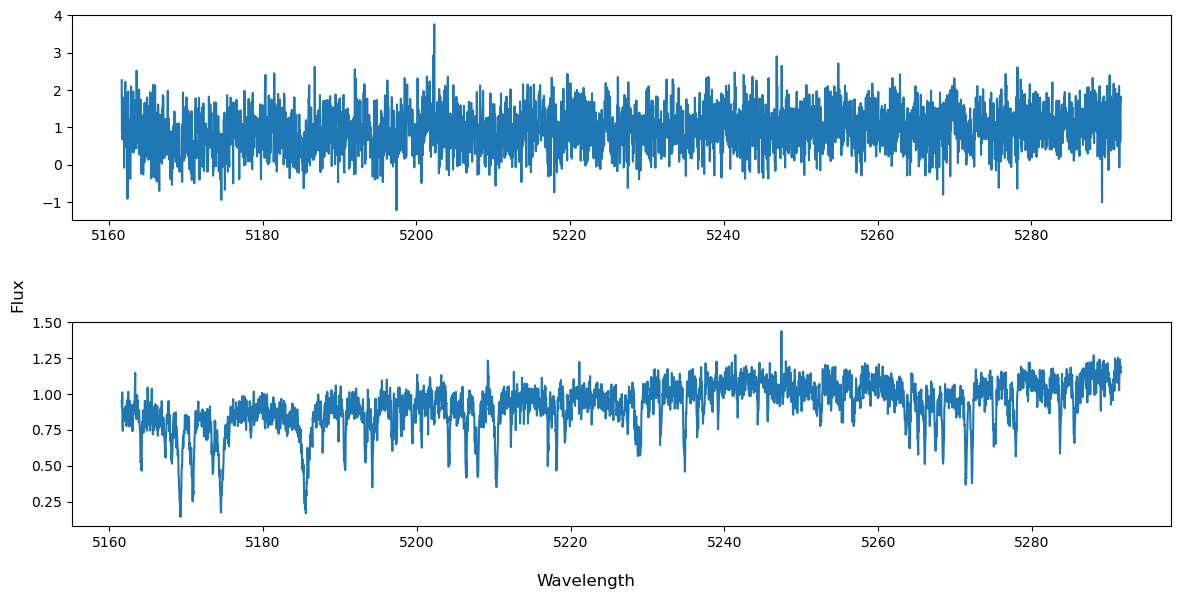

In [95]:
#gaia_id = 2128120908939932032
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128120908939932032)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0918_ngc6811_sep10_bright_1.6863.h5', gaiaid=2128120908939932032)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

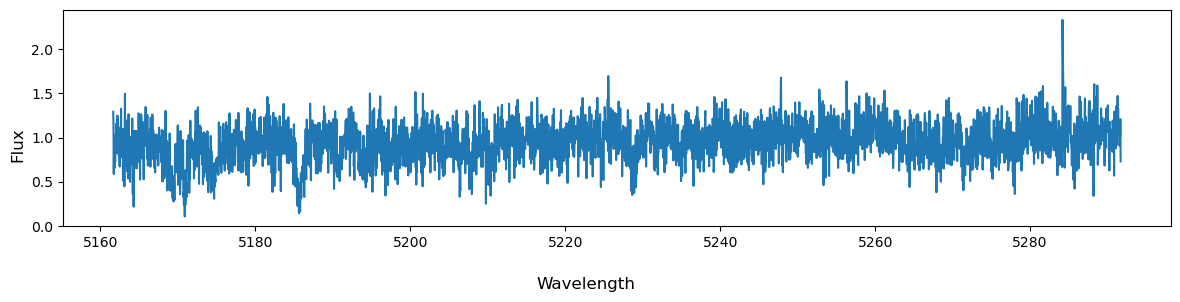

In [96]:
#gaia_id = 2128147125420433280
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128147125420433280)
ax.plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

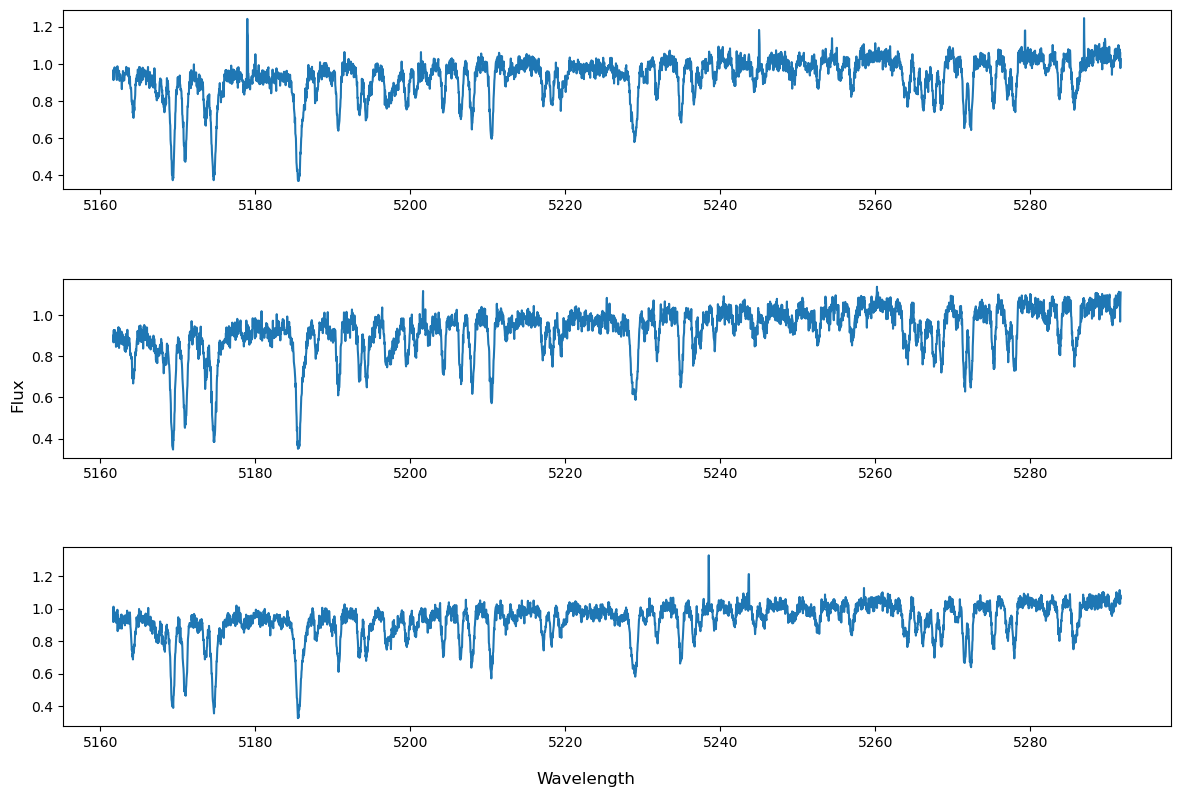

In [98]:
#gaia_id = 2128144857677611264
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2128144857677611264)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128144857677611264)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1202_ngc6811bright_nov09_3.4041.h5', gaiaid=2128144857677611264)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


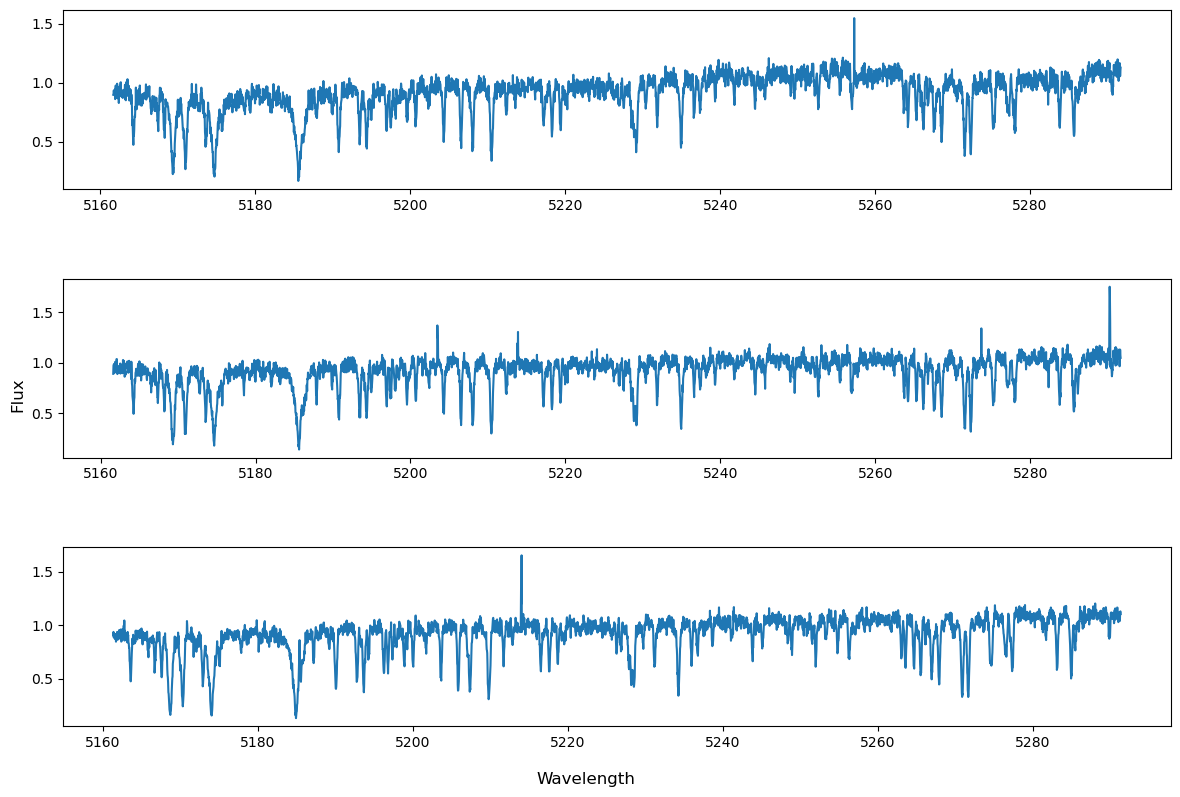

In [99]:
#gaia_id = 2128140425271501824
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1026_ngc6811_jul07_2.0447.h5', gaiaid=2128140425271501824)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1202_ngc6811bright_nov09_3.4041.h5', gaiaid=2128140425271501824)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0627_ngc6811_may2010_trunc_3.6386.h5', gaiaid=2128140425271501824)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

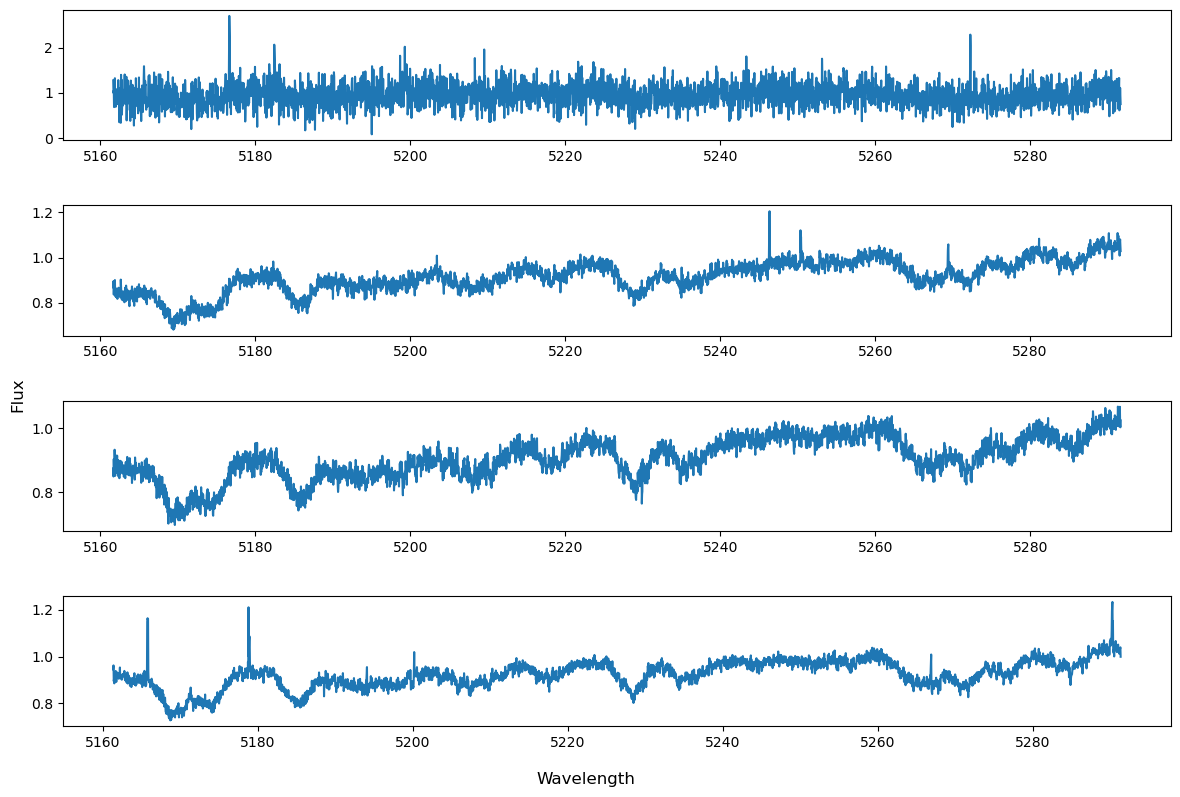

In [100]:
#gaia_id = 2128101804925014272
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128101804925014272)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128101804925014272)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1203_ngc6811bright_nov09_4.4154.h5', gaiaid=2128101804925014272)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0628_ngc6811_may2010_trunc_4.6455.h5', gaiaid=2128101804925014272)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


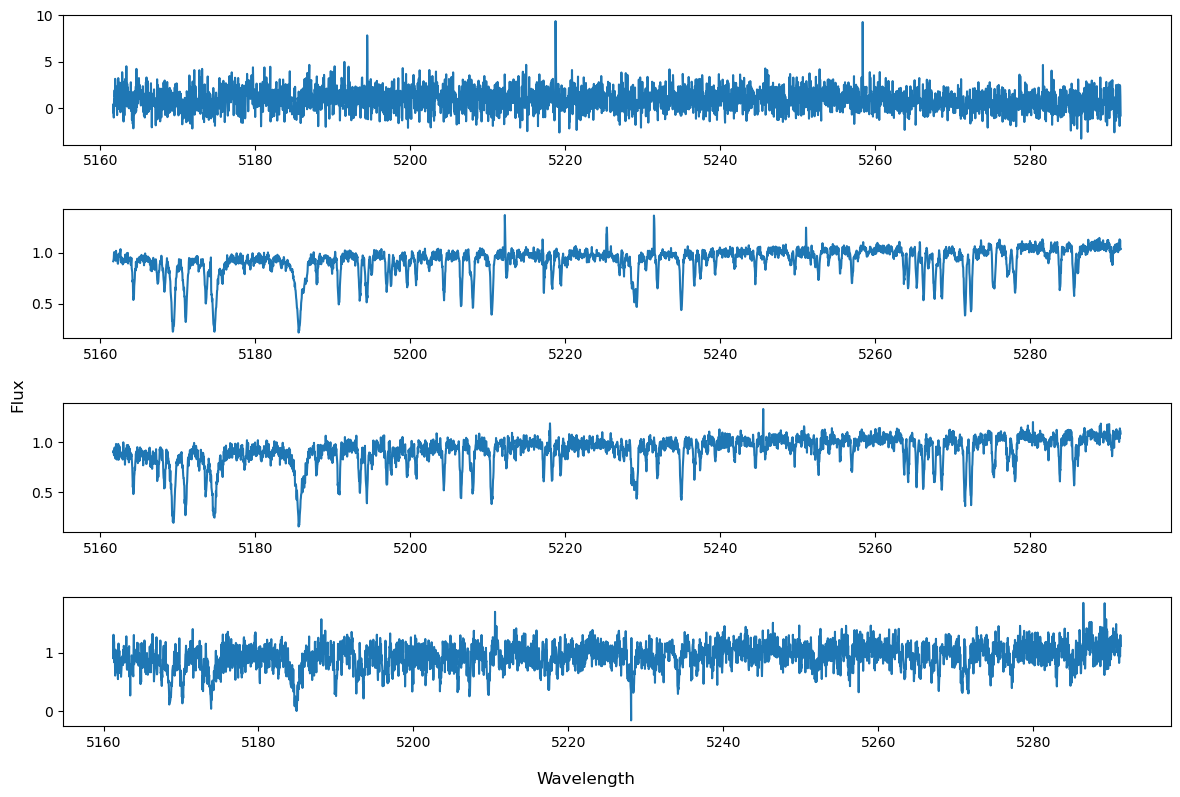

In [101]:
#gaia_id = 2128098849987500160
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128098849987500160)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1024_ngc6811_oct09_1.2828.h5', gaiaid=2128098849987500160)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2009.1127_ngc6811bright_nov09_1.3626.h5', gaiaid=2128098849987500160)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])
obs4 = getdata(catfile='Reduced Spectra/data_ngc6811_2012.0407_ngc6811_apr2012_bright_3.0729.h5', gaiaid=2128098849987500160)
ax[3].plot(obs4['spec']['obs_wave'], obs4['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y


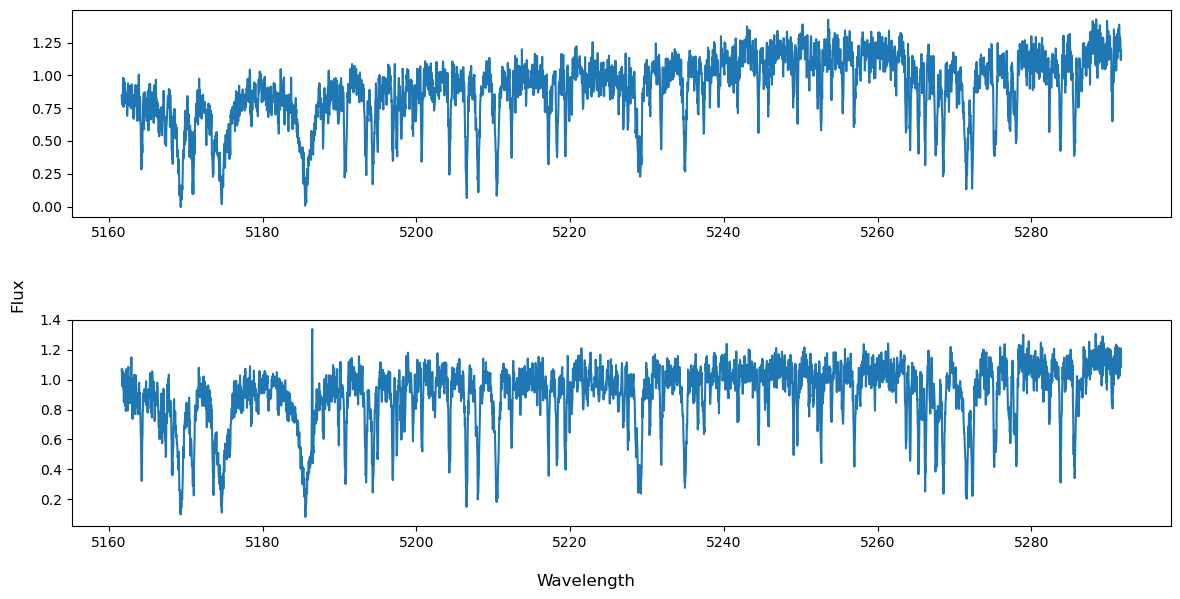

In [102]:
#gaia_id = 2128146713103563264
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128146713103563264)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.1121_ngc6811_sep10_faint_3.7448.h5', gaiaid=2128146713103563264)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y


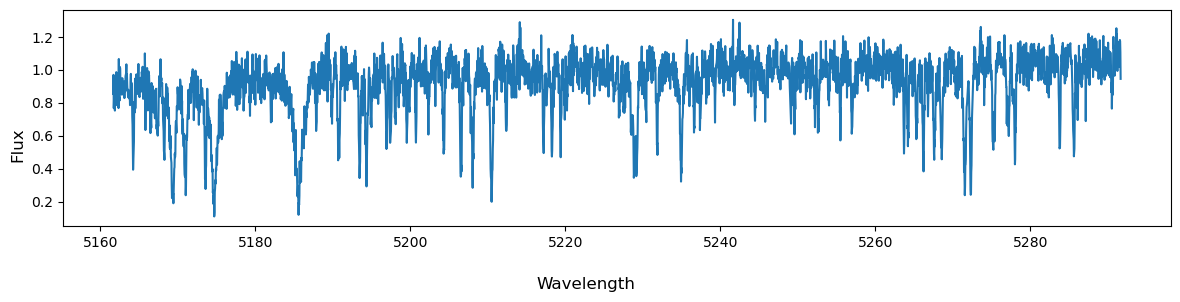

In [104]:
#gaia_id = 2128111975407524480
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2008.1019_ngc6811bright_jul08_2.2204.h5', gaiaid=2128111975407524480)
ax.plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

Skipping filter PS_y
Skipping filter PS_y
Skipping filter PS_y


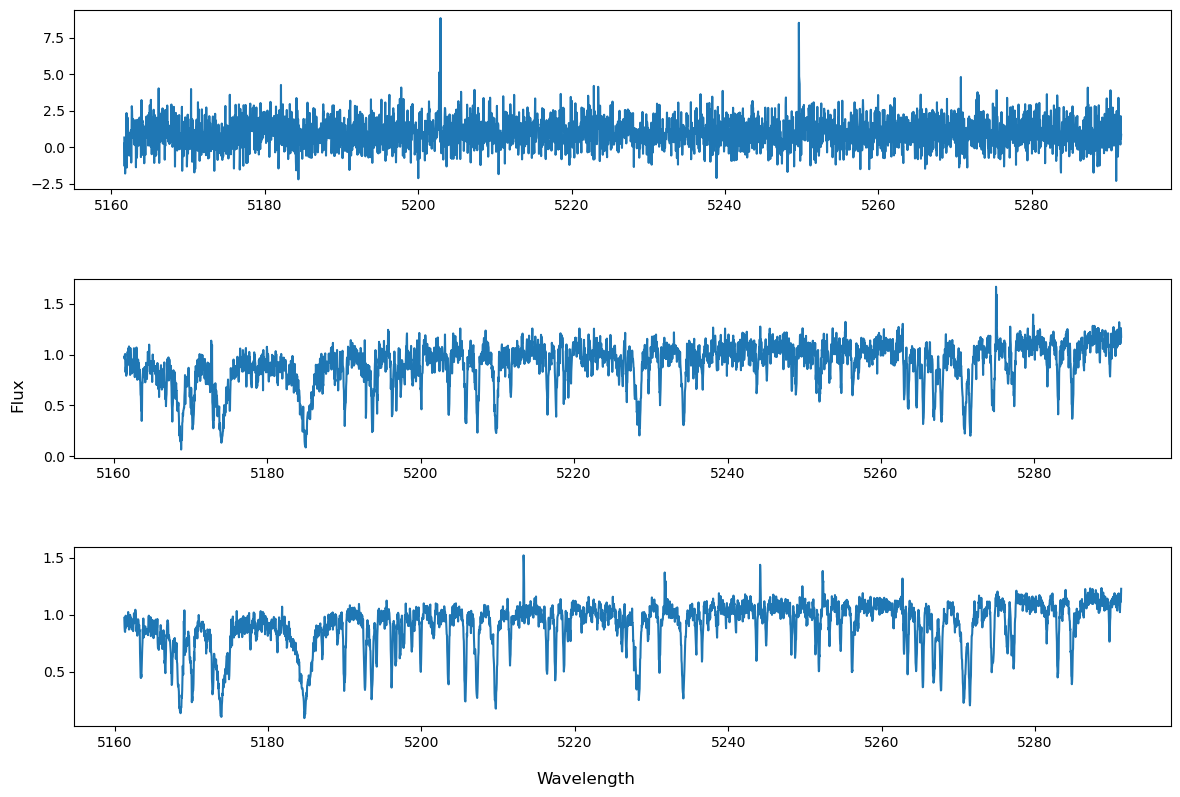

In [105]:
#gaia_id = 2128140253472804736
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

obs1 = getdata(catfile='Reduced Spectra/data_ngc6811_2007.1024_ngc6811_jul07_1.0200.h5', gaiaid=2128140253472804736)
ax[0].plot(obs1['spec']['obs_wave'], obs1['spec']['obs_flux'])
obs2 = getdata(catfile='Reduced Spectra/data_ngc6811_2010.0628_ngc6811_may2010_trunc_4.6455.h5', gaiaid=2128140253472804736)
ax[1].plot(obs2['spec']['obs_wave'], obs2['spec']['obs_flux'])
obs3 = getdata(catfile='Reduced Spectra/data_ngc6811_2016.0427_ngc6811_apr2016_1.3533.h5', gaiaid=2128140253472804736)
ax[2].plot(obs3['spec']['obs_wave'], obs3['spec']['obs_flux'])

fig.supxlabel("Wavelength")
fig.supylabel("Flux")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)